In [9]:
import tensorflow as tf

from srcnn.dataset import parse_function, prepare_input_image
from srcnn.plot import plot_dataset, plot_predictions, display_psnr

import calendar
import time
import os

In [10]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(kernel_size=(9, 9), filters=64, activation='relu'),  
  tf.keras.layers.Conv2D(kernel_size=(1, 1), filters=32, activation='relu'),
  tf.keras.layers.Conv2D(kernel_size=(5, 5), filters=3)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

<_UnbatchDataset shapes: ((32, 32, 3), (20, 20, 3)), types: (tf.float32, tf.float32)>


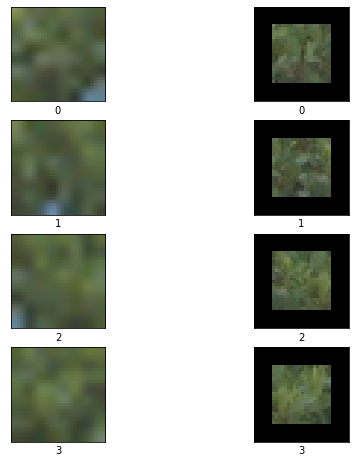

In [11]:
dataset = tf.data.Dataset.list_files(os.path.join("datasets", "Train", "*.bmp"))
dataset = dataset.flat_map(lambda f: parse_function(f, input_size=32, output_size=20, stride=14, scale=4)).unbatch()

print(dataset)
plot_dataset(dataset, n_patches=4)

batched_dataset = dataset.shuffle(1000).batch(100).repeat()

In [12]:
class ImageSRCallback(tf.keras.callbacks.Callback):
    def __init__(self, image_path, output_dir):
        super(ImageSRCallback, self).__init__()
        
        image = tf.image.decode_bmp(tf.io.read_file(image_path), channels=3)
        h, w, _ = image.get_shape()    
        self.input_image = prepare_input_image(image, h, w, scale=4)
        
        os.makedirs(output_dir, exist_ok=True)
        self.output_dir = output_dir
        
    def on_epoch_end(self, epoch, logs=None):
        predicted = self.model.predict(tf.stack([self.input_image]))[0]
        tf.io.write_file(os.path.join(self.output_dir, f'{epoch}.png'), tf.image.encode_png(tf.image.convert_image_dtype(predicted, dtype=tf.uint8)))
        

In [13]:
run_id=calendar.timegm(time.gmtime())
log_dir=os.path.join("logs", str(run_id))
print(f"Logs are saved to {log_dir}")

output_dir = "output"
os.makedirs(output_dir, exist_ok=True)
model.fit(batched_dataset, epochs=3000, steps_per_epoch=100, callbacks=[tf.keras.callbacks.TensorBoard(log_dir=log_dir),
                                                                        ImageSRCallback(os.path.join("datasets", "Train", "t51.bmp"), os.path.join(output_dir, str(run_id), "progress"))])

Logs are saved to logs/1570108942
Train for 100 steps
Epoch 1/3000
100/100 [==============================] - 8s 79ms/step - loss: 0.0149 - accuracy: 0.8271
Epoch 2/3000
100/100 [==============================] - 8s 77ms/step - loss: 0.0041 - accuracy: 0.9414
Epoch 3/3000
100/100 [==============================] - 7s 74ms/step - loss: 0.0046 - accuracy: 0.9123
Epoch 4/3000
100/100 [==============================] - 8s 79ms/step - loss: 0.0042 - accuracy: 0.9452
Epoch 5/3000
100/100 [==============================] - 8s 78ms/step - loss: 0.0037 - accuracy: 0.9304
Epoch 6/3000
100/100 [==============================] - 8s 77ms/step - loss: 0.0043 - accuracy: 0.9492
Epoch 7/3000
100/100 [==============================] - 8s 76ms/step - loss: 0.0038 - accuracy: 0.9312
Epoch 8/3000
100/100 [==============================] - 8s 80ms/step - loss: 0.0041 - accuracy: 0.9544
Epoch 9/3000
100/100 [==============================] - 8s 75ms/step - loss: 0.0044 - accuracy: 0.9357
Epoch 10/3000
100/1

,Image Name,PSNR: Input,PSNR: SRCNN
0,patch 0,25.487,25.629
1,patch 1,23.327,23.496
2,patch 2,25.384,24.978
3,patch 3,25.210,25.627
4,patch 4,26.532,26.511
5,patch 5,27.115,28.378


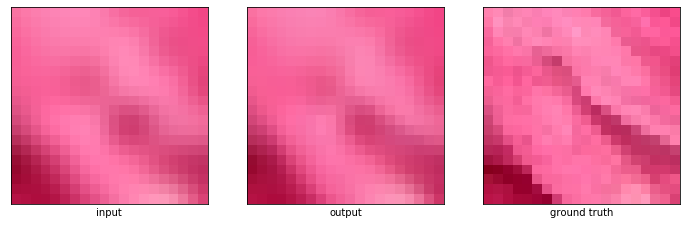

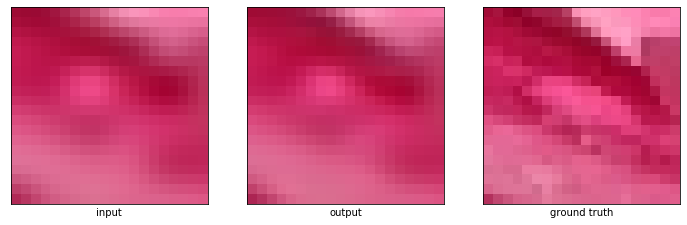

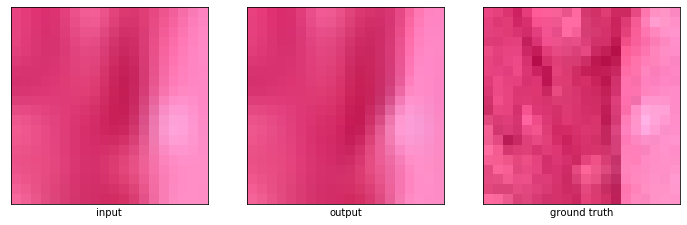

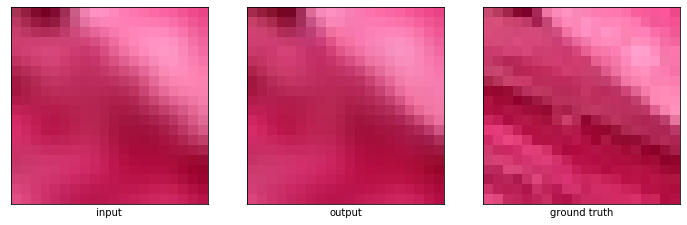

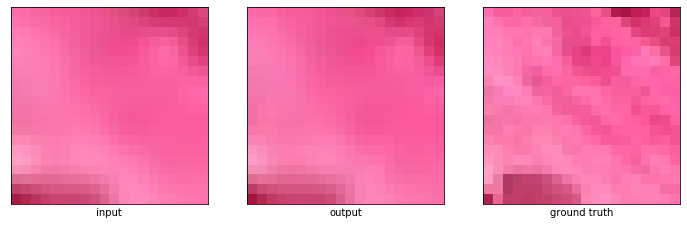

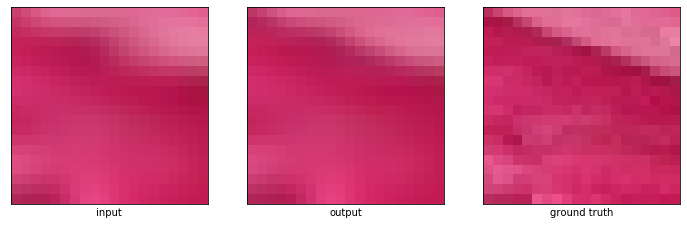

In [14]:
def plot_predictions_on_dataset(d, model, count):
    d_small = d.shuffle(100).take(count)
    
    names = []
    inputs = []
    ground_truth = []
    identity = lambda x, y: (x, y)
    for c, (i, g) in enumerate(d_small.map(identity)):
        names.append(f'patch {c}')
        inputs.append(i)
        ground_truth.append(g)
    
    psnr = plot_predictions(model, names, inputs, ground_truth)
    display_psnr(psnr)
    

plot_predictions_on_dataset(dataset, model, 6)

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            multiple                  15616     
_________________________________________________________________
conv2d_4 (Conv2D)            multiple                  2080      
_________________________________________________________________
conv2d_5 (Conv2D)            multiple                  2403      
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________


In [16]:
model_dir='models'
os.makedirs(model_dir, exist_ok=True)
    
model_path = os.path.join(model_dir, f"{run_id}.h5")
model.save(model_path)